We implement the simplest possible reinforcement learning agent: a youtube thumbnail chooser. Which thumbnail get's the most clicks? From scratch, we code up action selection, reward tracking, and incremental updates for estimating action values. This lecture focuses on (1) the idea of learning through interaction with an environment, (2) incremental gradient-like updates without backpropagation, and (3) the core concepts of exploration vs. exploitation.

### The environment 
Before we can learn anything, our agent needs a 'world' to understand. This is called the environment. You can think about the world you live in, but it actually get's even better. We can use that world, or any other world we like! It's up to us to define! In essence, we can make it anything we want. It is why we often say 'environment' and not 'world'. Let's make a world in where our agent can take actions and do stuff. We will make a class which will hold the *secret click-through rate* for each thumbnail. Our agent never get's to see these probabilities, it needs to discover them itself!

In [9]:
import numpy as np
import matplotlib.pyplot as plt

class YouTubeEnvironment:
    def __init__(self, thumbnail_names):
        self.thumbnail_names = thumbnail_names
        self.k = len(thumbnail_names)

        # make the 'true' CTR's. This is the secret the agent have to find out
        self._true_ctrs = np.random.rand(self.k)
        self._best_thumb_idx = np.random.randint(0, self.k)
        self._true_ctrs[self._best_thumb_idx] = np.random.uniform(0.15, 0.25)  # En thumbnail is a clear winner (15-25% click-trough-rate)
        for i in range(self.k):
            if i != self._best_thumb_idx:
                self._true_ctrs[i] = np.random.uniform(0.02, 0.08)      # The other are less good (2-8% click through)

    def show_thumbnail(self, thumb_index):
        """
        Simulates that a user on YouTube sees a thumbnail
        Returns a reward of +1 if clicks, 0 if not
        """
        ctr = self._true_ctrs[thumb_index] # pick the "true dynamics", the hidden secret rate for this thumbnail, for this environment
        if np.random.rand() < ctr:         # simulating how likely the user is to click
            return 1  # click!
        else:
            return 0  # no click!

More relevant for the RL course
Well, how would you solve *any* problem where you're trying to discover something you don't know? Maybe you just give up and say that *bah the complexity of the world, or just or data, is so great I'm not able to just write down the answer or even make any progress on this*.

And here is where we make a foundational descision. The first step of breaking down this problem is to say: **the system has to learn for itself**

In [10]:
thumbnails = ["😮 SHOCKING!", "Clean code tutorial", "😂 Fun things"]
youtube_env = YouTubeEnvironment(thumbnails)

In [11]:
for i, name in enumerate(youtube_env.thumbnail_names):
    print(f" - Thumbnail {i}: '{name}'")

 - Thumbnail 0: '😮 SHOCKING!'
 - Thumbnail 1: 'Clean code tutorial'
 - Thumbnail 2: '😂 Fun things'



#### Let's just sneak on the *secret* CTR our agent will have to learn (only we know this)


In [12]:
for i, (name, ctr) in enumerate(zip(youtube_env.thumbnail_names, youtube_env._true_ctrs)):
    print(f"'{name}' has a true CTR of {ctr:.2%}")

'😮 SHOCKING!' has a true CTR of 4.55%
'Clean code tutorial' has a true CTR of 3.55%
'😂 Fun things' has a true CTR of 20.83%


In [8]:
best_idx = np.argmax(youtube_env._true_ctrs)
print(f"\nThe objectively best thumbnail is '{youtube_env.thumbnail_names[best_idx]}'.")


The objectively best thumbnail is '😮 SHOCKING!'.


### A naive agent (random agent)
What is the most naiv strategy we can think of? Just pick an arm randomly every time. This is 100% exploration. The agent tries everything, but never uses any info it has learned to make better choices. 

Let's just see how bad or well our agent actually does. This will be our baseline

In [63]:
num_views = 2000
k = youtube_env.k

total_clicks_random = 0
history_random = []      # store the history, so we can do some "Science" with it.

for view in range(num_views):
    # Velg en tilfeldig thumbnail å vise
    thumb_choice = np.random.randint(0, k) 
    
    # Få resultatet fra miljøet
    reward = youtube_env.show_thumbnail(thumb_choice)
    
    total_clicks_random += reward                 # accumulate the total number of clicks
    history_random.append((thumb_choice, reward)) # remember what we showed and the feedback from showing it

avg_ctr_random = total_clicks_random / num_views
print(f"Resultat for 'Magefølelse'-agenten:")
print(f"Totalt antall klikk etter {num_views} visninger: {total_clicks_random}")
print(f"Gjennomsnittlig CTR oppnådd: {avg_ctr_random:.2%}")

# Sammenlign med den teoretiske gjennomsnittlige CTR-en
print(f"Teoretisk gjennomsnittlig CTR: {np.mean(youtube_env._true_ctrs):.2%}")

Resultat for 'Magefølelse'-agenten:
Totalt antall klikk etter 2000 visninger: 212
Gjennomsnittlig CTR oppnådd: 10.60%
Teoretisk gjennomsnittlig CTR: 9.65%


So, what does this mean? We have throwed and picked a thumbnail to show to a YouTube user **completely at random**. And *in the end, we ended up with 246 clicks*. Is this <span style="color:green">good</span> or <span style="color:red">bad</span>?

Well, the 'hidden distribution' shows us that *if we were to just pick one of the thumbnails at random* we could expect to get something like 12.28% click-through. So basically, a thumbnail shown 100 times, gets clicked on a little over 12 times.

We were around 12 clicks per 100 thumbnails shown, so I guess this is pretty <span style="color:gray">neutral</span> compared to random guessing, but the thought of a monkey doing just as well as our fancy machine learning approach is not worth that much?

People in charge of YouTube, Instagram, Snapchat or TikTok often care about this number, because it is a direct measure of **engagement**. For all these platforms, if CTR is high, it means people will *spend a lot of time on the site, clicking on things*, and often this can lead them to watch or buy things. On the other hand, if CTR is low, it means most people are ignoring it. 

##### Example to understand the concept: 

- Suppose Google shows an ad 10 000 times
- CTR = 2% -> 200 people clicked.
- CTR = 5% -> 500 people clicked (that's 2.5x more business).

In our case, '😂 Fun things' has the potential for 23% click-through rate, which is *golden*. **Learning** that this is the best, would nearly double youe clicks compared to random guessing. The motivation is clear, but how do we get there?

##### The first step to intelligence: looking at the data
Our random agent threw 2000 thumbnails on our poor YouTube viewers. It wasn't doing anything with the feedback, right? We just threw thumbnails at random and measured how much they got clicked on. In some sense it was a terrible strategist but a decent scientist. It effectively ran a random experiment for us lol!

Maybe you think, let's go through the history of our 2000 random trials and simply count, for each thumbnail: 
1. How many times was it shown?
2. how many clicks did it get?

From this, we can calculate an *observed* CTR for each one. Let's see what the data from our random experiment tells us:

In [29]:
# look at the history we actually experienced
for thumbnail, reward in history_greedy[:20]:
    print(f"Thumbnail shown: {thumbnails[thumbnail]}, Reward we got: {reward}")

Thumbnail shown: 😮 SHOCKING!, Reward we got: 0
Thumbnail shown: Clean code tutorial, Reward we got: 0
Thumbnail shown: 😂 Fun things, Reward we got: 1
Thumbnail shown: 😂 Fun things, Reward we got: 1
Thumbnail shown: 😂 Fun things, Reward we got: 1
Thumbnail shown: 😂 Fun things, Reward we got: 0
Thumbnail shown: 😂 Fun things, Reward we got: 1
Thumbnail shown: 😂 Fun things, Reward we got: 1
Thumbnail shown: 😂 Fun things, Reward we got: 0
Thumbnail shown: 😂 Fun things, Reward we got: 0
Thumbnail shown: 😂 Fun things, Reward we got: 0
Thumbnail shown: 😂 Fun things, Reward we got: 0
Thumbnail shown: 😂 Fun things, Reward we got: 1
Thumbnail shown: 😂 Fun things, Reward we got: 0
Thumbnail shown: 😂 Fun things, Reward we got: 1
Thumbnail shown: 😂 Fun things, Reward we got: 0
Thumbnail shown: 😂 Fun things, Reward we got: 0
Thumbnail shown: 😂 Fun things, Reward we got: 0
Thumbnail shown: 😂 Fun things, Reward we got: 1
Thumbnail shown: 😂 Fun things, Reward we got: 0


In [67]:
# Let's analyse that history:
view_counts = np.zeros(k)
click_counts = np.zeros(k)
for thumb_idx, reward in history_random:
    view_counts[thumb_idx] += 1
    click_counts[thumb_idx] += reward

In [68]:
np.zeros(3)

array([0., 0., 0.])

In [69]:
# So, what did we observe?
# (note: you should stribe to avoid division by zero if a thumbnail was never shown (unlikely, but good practice))
observed_ctrs = click_counts / view_counts

In [71]:
print("--- Analysis of what we actually experienced just throwing random thumbnails on poor YouTubers ---")
for i in range(k):
    print(f"Thumbnail #{i} ('{youtube_env.thumbnail_names[i]}'):")
    print(f"  - Shown: {int(view_counts[i])} times")
    print(f"  - Clicked: {int(click_counts[i])} times")
    print(f"  - Observed CTR: {observed_ctrs[i]:.2%}\n")

--- Analysis of what we actually experienced just throwing random thumbnails on poor YouTubers ---
Thumbnail #0 ('😮 SHOCKING!'):
  - Shown: 696 times
  - Clicked: 19 times
  - Observed CTR: 2.73%

Thumbnail #1 ('Clean code tutorial'):
  - Shown: 646 times
  - Clicked: 46 times
  - Observed CTR: 7.12%

Thumbnail #2 ('😂 Fun things'):
  - Shown: 658 times
  - Clicked: 128 times
  - Observed CTR: 19.45%



Aha! Based on this <span style="color:purple">collected experience</span>, we can actually **use what we have experienced** to estimate what we *should show* in the next round. Maybe we should try to *exploit* this information from the experiment we actually ran just now?! 

We would think that we should  show a lot more fun things than shocking things or coding tutorials.

In [72]:
# So, to summarize, the best thumbnail based on what we experienced is:
best_observed_idx = np.argmax( )
print(f"'{youtube_env.thumbnail_names[best_observed_idx]}' looks like the best one to show for clicks")

'😂 Fun things' looks like the best one to show for clicks


OK, so our <span style="color:purple">actual experience</span> shows that *one thumbnail* performed much better than the others.

So our genius idea is now
> What is we just always show the thumbnail that has performed the best so far?


### A bit smarter agent (greedy strategy)


Let's remind ourselves of the situation

- There are several YouTube thumbnails
- Each thumbnail has a secret probability to getting a click
- You don't know these probabilities. The only way to learn them is by trial and error and see what works

However, this time we have a strategy that is **not random**, but we are going to **pick the best choice as we go**.

In [86]:
# So, we start with some guesses (we assume each thumbnail gets about 10% click rate). 
ctr_estimates_greedy = np.ones(k) * 0.1 
ctr_estimates_greedy[1] = 0.7  # uncomment this to play with the argmax to understand it
ctr_estimates_greedy

array([0.1, 0.7, 0.1])

In [74]:
# and we use something to store our experience of which thumbnail gets clicks
view_counts_greedy = np.zeros(k)
view_counts_greedy

array([0., 0., 0.])

In [87]:
# the index of the thumbnail to show
np.argmax(ctr_estimates_greedy).item()

1

In [105]:
# each time, we look at our guesses of the best one and pick the one with the biggest number. That's what argmax does
best_thumb_guess_idx = np.argmax(ctr_estimates_greedy)
reward = youtube_env.show_thumbnail(best_thumb_guess_idx) # here the thumbnail we chose, did not get clicked on, urg!
reward

1

So then, we have have observed that we did not get a click, we need to use this result to **update our beliefs**

In [113]:
old_estimate = ctr_estimates_greedy[1] # remember what we had as an estimate for this thumbnail
old_estimate # 10% of course

np.float64(0.7)

In [132]:
view_counts = 0
thumb_choice = 1
view_counts_greedy[thumb_choice] += 1
print(f"view counts: {view_counts_greedy}")
reward = 0
old_estimate + (1 / view_counts_greedy[thumb_choice]) * (reward - old_estimate)

view counts: [ 0. 18.  0.]


np.float64(0.6611111111111111)

So the **rule is** really:
- If the reward was higher than your old guess, the estimate goes up.
- If the reward was lower, the estimate goes down.
- The more times you’ve shown the thumbnail, the smaller the adjustments get.

Let's try it out, just to see that we actually get the behaviour we want:

In [133]:
0.1 + (1/1) * (0 - 0.1) # shown the second thumbnail two times -> we got zero reward, so the estimate of it's value goes down

0.0

In [134]:
# if we show it again, and still get no reward, we didn't actually expect anything, so we stay put at zero
0.0 + (1/2) * (0 - 0) # shown the second thumbnail two times -> we got zero reward, so the estimate of it's value is still 0

0.0


##### Greedy agent


In [30]:
ctr_estimates_greedy = np.ones(k) * 0.1 
view_counts_greedy = np.zeros(k)

total_clicks_greedy = 0
history_greedy = []

for view in range(num_views):
    # Velg den thumbnailen med den høyeste ESTIMERTE CTR-en
    thumb_choice = np.argmax(ctr_estimates_greedy)    # Choose the one with the highest estimate now
    
    reward = youtube_env.show_thumbnail(thumb_choice) # Pass the action to the environment and get the reward back
    
    total_clicks_greedy += reward # remember the total clicks we get
    history_greedy.append((thumb_choice, reward)) # remember the reward we got
    
    # Oppdater agentens kunnskap (inkrementelt gjennomsnitt)
    view_counts_greedy[thumb_choice] += 1    # update how many times we have shown this thumbnail that we are currently showing
    old_estimate = ctr_estimates_greedy[thumb_choice] # remember our old estimate of how good it was
    
    # Formel: New_Avg = Old_Avg + (1/N) * (New_Value - Old_Avg)
    ctr_estimates_greedy[thumb_choice] = old_estimate + (1 / view_counts_greedy[thumb_choice]) * (reward - old_estimate)

print(f"Resultat for 'Greedy' agent:")
print(f"Totalt antall klikk etter {num_views} total clicks: {total_clicks_greedy}")
print(f"Gjennomsnittlig CTR oppnådd: {total_clicks_greedy/num_views:.2%}")
print("\nFinal estimates for CTR:")
for i, name in enumerate(youtube_env.thumbnail_names):
    print(f" - '{name}': {ctr_estimates_greedy[i]:.2%}")

Resultat for 'Greedy' agent:
Totalt antall klikk etter 2000 total clicks: 78
Gjennomsnittlig CTR oppnådd: 3.90%

Final estimates for CTR:
 - '😮 SHOCKING!': 3.90%
 - 'Clean code tutorial': 0.00%
 - '😂 Fun things': 0.00%



##### Explore and commit


In [158]:
ctr_estimates_explore_commit = [0.0273, 0.0712, 0.1945]
view_counts_explore_commit = np.zeros(k)

total_clicks_explore_commit = 0
history_explore_commit = []

for view in range(num_views):
    # Velg den thumbnailen med den høyeste ESTIMERTE CTR-en
    thumb_choice = np.argmax(ctr_estimates_explore_commit)    # Choose the one with the highest estimate now
    
    reward = youtube_env.show_thumbnail(thumb_choice) # Pass the action to the environment and get the reward back
    
    total_clicks_explore_commit += reward # remember the total clicks we get
    history_explore_commit.append((reward, thumb_choice)) # remember the reward we got
    
    # Oppdater agentens kunnskap (inkrementelt gjennomsnitt)
    view_counts_greedy[thumb_choice] += 1    # update how many times we have shown this thumbnail that we are currently showing
    #old_estimate = ctr_estimates_greedy[thumb_choice] # remember our old estimate of how good it was
    
    # Formel: New_Avg = Old_Avg + (1/N) * (New_Value - Old_Avg)
    #ctr_estimates_greedy[thumb_choice] = old_estimate + (1 / view_counts_greedy[thumb_choice]) * (reward - old_estimate)

print(f"Resultat for 'Greedy' agent:")
print(f"Totalt antall klikk etter {num_views} total clicks: {total_clicks_explore_commit}")
print(f"Gjennomsnittlig CTR oppnådd: {total_clicks_explore_commit/num_views:.2%}")
print("\nFinal estimates for CTR:")
for i, name in enumerate(youtube_env.thumbnail_names):
    print(f" - '{name}': {ctr_estimates_explore_commit[i]:.2%}")

Resultat for 'Greedy' agent:
Totalt antall klikk etter 2000 total clicks: 425
Gjennomsnittlig CTR oppnådd: 21.25%

Final estimates for CTR:
 - '😮 SHOCKING!': 2.73%
 - 'Clean code tutorial': 7.12%
 - '😂 Fun things': 19.45%


Okay, so where are we now?

We have seen that we clearly need to **explore** our environment to even be able to find the hidden truth. So random throwing of thumbnails does not get us where we want, and just updating our estimate as we go, but always picking the best one we've seen *so far*, also does not work that well, because we often get stuck locking in on a suboptimal choice. It's like a gambler with a bad risk advisor, lol.

We have also seen that the combination of a lot of exploring first, then see what happened and then adjusting our strategy based on that experience, so far gave us the best result.

So, are we done? Yes, in principle we could just explore first, then see what happened and always pick the best strategy based on that experience. 

----

But, we're not. Because what will happen if by chance what we experienced was *not* the hidden secret best, or even close to it? But something was up with YouTube that week, and you got some weird clicks, and all of a sudden it looked like the *'Clean code tutorial'* was the thumbnail with the highest click through, at around 20%. 

So we choose to show this forever, 

Now, due to the hidden secret or *true* click rate of the *'Clean code tutorial'* is 6.95% you get about 6 clicks per 100 views. The best you could have done is about 20 clicks per 100. You are throwing away about 14 clicks every 100 views. Over a million views that is roughly 140,000 lost clicks. The mistake came from a weird, noisy week that happened to flatter the wrong thumbnail, and your commit rule gave that noisy result infinite weight. There is no recovery mechanism. **You learned once, then stopped learning.**


#### Keeping a trickle of curiosity alive forever


Now, we don't have fancy theory, but we just do the most naive thing. We say; okay, I'm actually going to do the *what is best right now*-thing that I've seen have this potential, but let's just keep some exploring alive **always**, *and update our estimates as we go*. We will call this ε-greedy. Epsilon for exploration :)

So, what happens now when you are unlucky as in the weird week we just talked about? Well, we mostly show the *Clean code tutorial*, because we happened to get signals that this was the best, but we will also still show something else as we go, so maybe we show some *'😂 Fun things'* once in a while. How often is not so important, let's just say 10%. 

Okay, so 90% of the time, we prick what we think is best based on our experience, but once in a whlie - 10% of the time, we will actually just try a random thumbnail.


##### ε-Greedy agent


In [60]:
epsilon = 0.1
ctr_estimates_egreedy = np.ones(k) * 0.1 
view_counts_egreedy = np.zeros(k)

total_clicks_egreedy = 0
history_egreedy = []

for view in range(num_views):
    # Velg den thumbnailen med den høyeste ESTIMERTE CTR-en
    thumb_choice = np.random.randint(0, k) if np.random.rand() < epsilon else np.argmax(ctr_estimates_egreedy)
    
    reward = youtube_env.show_thumbnail(thumb_choice) # Pass the action to the environment and get the reward back
    
    total_clicks_egreedy += reward # remember the total clicks we get
    history_egreedy.append((thumb_choice, reward)) # remember the reward we got
    
    # Oppdater agentens kunnskap (inkrementelt gjennomsnitt)
    view_counts_egreedy[thumb_choice] += 1    # update how many times we have shown this thumbnail that we are currently showing
    old_estimate = ctr_estimates_egreedy[thumb_choice] # remember our old estimate of how good it was
    
    # Formel: New_Avg = Old_Avg + (1/N) * (New_Value - Old_Avg)
    ctr_estimates_egreedy[thumb_choice] = old_estimate + (1 / view_counts_egreedy[thumb_choice]) * (reward - old_estimate)

print(f"Resultat for 'ε-Greedy' agent:")
print(f"Totalt antall klikk etter {num_views} total clicks: {total_clicks_egreedy}")
print(f"Gjennomsnittlig CTR oppnådd: {total_clicks_egreedy/num_views:.2%}")
print("\nFinal estimates for CTR:")
for i, name in enumerate(youtube_env.thumbnail_names):
    print(f" - '{name}': {ctr_estimates_egreedy[i]:.2%}")

Resultat for 'ε-Greedy' agent:
Totalt antall klikk etter 2000 total clicks: 352
Gjennomsnittlig CTR oppnådd: 17.60%

Final estimates for CTR:
 - '😮 SHOCKING!': 3.48%
 - 'Clean code tutorial': 1.52%
 - '😂 Fun things': 19.08%



-----

Final estimates for CTR (Greedy):
 - '😮 SHOCKING!': 4.65%
 - 'Clean code tutorial': 0.00%
 - '😂 Fun things': 0.00%


#### Visualisation


In [71]:
def _rewards(history):
    return np.fromiter((r for _, r in history), dtype=float)

def moving_average_ctr_xy(history, window_size=100):
    r = _rewards(history)
    if r.size == 0: return np.array([]), np.array([])
    w = min(window_size, r.size)
    y = np.convolve(r, np.ones(w), mode='valid') / w
    x = np.arange(w-1, w-1 + y.size)  # index of the right edge of each window
    return x, y

def cumulative_ctr(history):
    r = _rewards(history)
    if r.size == 0: return r
    return np.cumsum(r) / np.arange(1, r.size + 1)

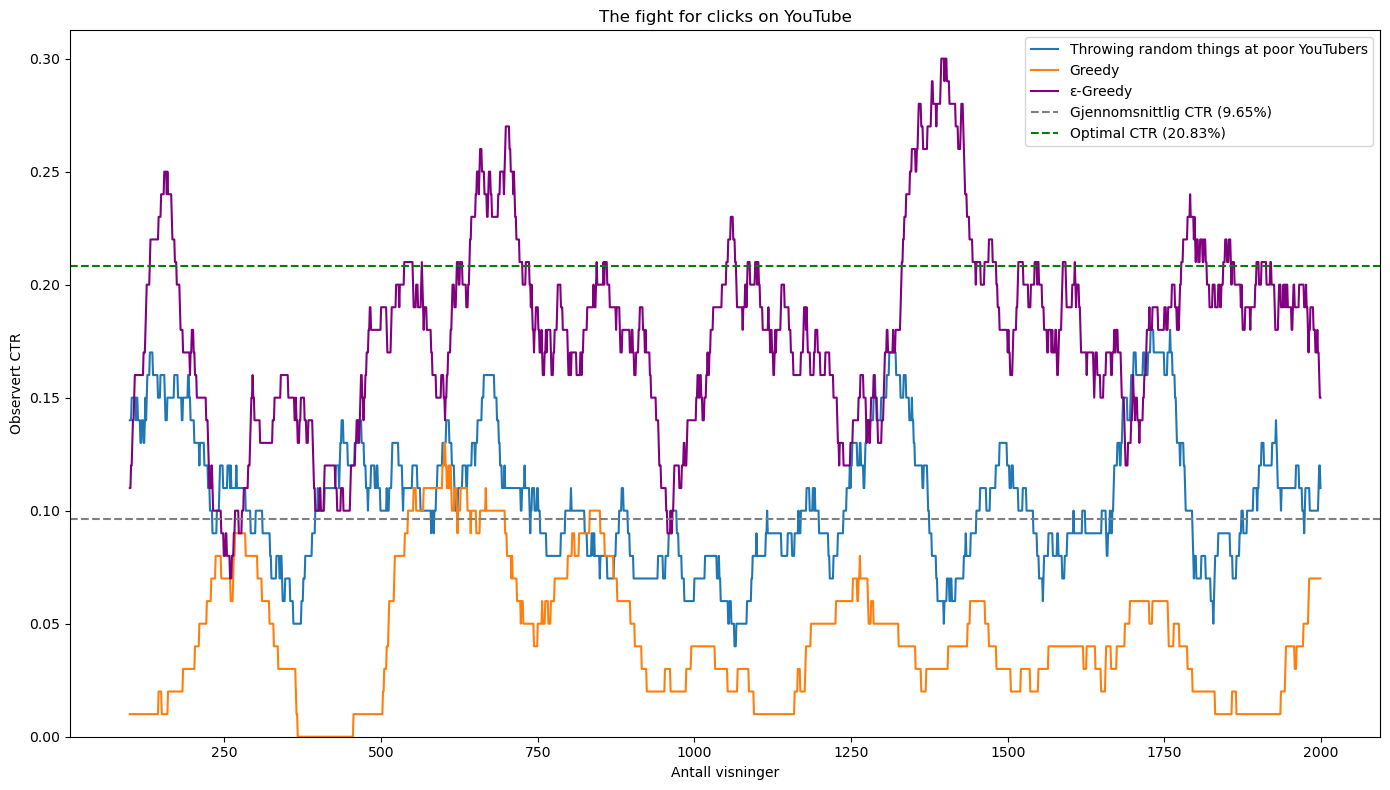

In [78]:
plt.figure(figsize=(14, 8))
# Curves
x, y = moving_average_ctr_xy(history_random, window_size=100)
plt.plot(x, y, label="Throwing random things at poor YouTubers")

x, y = moving_average_ctr_xy(history_greedy, window_size=100)
plt.plot(x, y, label="Greedy")  # default orange

x, y = moving_average_ctr_xy(history_egreedy, window_size=100)
plt.plot(x, y, color="purple", label="ε-Greedy")  # force purple

plt.axhline(y=np.mean(youtube_env._true_ctrs), color="gray", linestyle='--',
            label=f'Gjennomsnittlig CTR ({np.mean(youtube_env._true_ctrs):.2%})')
plt.axhline(y=np.max(youtube_env._true_ctrs), color="green", linestyle='--',
            label=f'Optimal CTR ({np.max(youtube_env._true_ctrs):.2%})')

plt.title('The fight for clicks on YouTube')
plt.xlabel('Antall visninger')
plt.ylabel('Observert CTR')
plt.legend()
plt.ylim(0, np.max(youtube_env._true_ctrs) * 1.5)
plt.tight_layout()
plt.show()

Okay, so the plot speaks for itself. YouBandit ε-Greedy is clearly the <span style="color:green">winner</span>.

Throwing things at random get's us around the mean of the *hidden secret* rates. Just showing the best thing we have seen so far, without exploring as we go, actually does <span style="color:red">worse</span> than random. Not good. We are potentially locking on to a really bad action *forever* and misses what is **actually best**.

YouBandit finds the perfect balance, mostly picking what is believed to be best as we go, but once in a while, throwing on some random thumbnail to see if we can do better by showing something else.

---
So, what have we built so far?
1. An agent what solves a real, modern problem of what video to show on YouTube to get the most clicks.
2. A deeper understanding of the critical problem of exploration and exploitation, that is special to Reinforcement Learning.
3. Our first <span style="color:purple">'learning rule'</span>, which was to update what we *tought was best* towards the *difference of what we actually experienced and what we thought*.